# Predicting Entries by Day with Snow #

In this notebook we demonstrate the ability to improve entry prediction on the MBTA by adding a "snow" feature to our model.

## Setup ##

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib, matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn import grid_search

from sklearn import linear_model

from sklearn.metrics import mean_squared_error

% matplotlib inline

## Import Data ##
Import the MBTA daily csv file which contains the entries per day for each station. This data set has also removed typical holidays to the reduce the amount of known outliers.

In [36]:
data = pd.read_csv("../../../../data/mbta_daily_noholidays_games.csv", low_memory=False)
data.head()

,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,rain_fall_predict,snow_predict,snow_fall_predict,snow_accum,snow_accum_predict,dist_to_center,date,bruins_game,celtics_game,sox_game
0,1002,2013-01-02 00:00:00,5134,Andrew Square,Red,NaN,42.329550,-71.056960,2013-01-02 04:45:00,0,...,0,0,0,0,0,3.404767,2013-01-02 00:00:00,0,1,0
1,1004,2013-01-02 00:00:00,4891,JFK/U Mass,Red,NaN,42.321438,-71.052393,2013-01-02 04:45:00,0,...,0,0,0,0,0,4.328881,2013-01-02 00:00:00,0,1,0
2,1005,2013-01-02 00:00:00,5879,North Quincy,Red,NaN,42.274816,-71.029176,2013-01-02 04:45:00,0,...,0,0,0,0,0,9.777437,2013-01-02 00:00:00,0,1,0
3,1006,2013-01-02 00:00:00,3901,Wollaston,Red,NaN,42.265615,-71.019402,2013-01-02 03:45:00,0,...,0,0,0,0,0,10.976943,2013-01-02 00:00:00,0,1,0
4,1007,2013-01-02 00:00:00,7092,Quincy Center,Red,NaN,42.250879,-71.004798,2013-01-02 05:00:00,0,...,0,0,0,0,0,12.909591,2013-01-02 00:00:00,0,1,0


## Filter Weekdays ##
Filter the data so we are only predicting weekdays. Weekends have a pattern of their own, so we're going to ignore them for this module.

In [37]:
data = data[(pd.DatetimeIndex(data['service_day']).weekday != 5) & (pd.DatetimeIndex(data['service_day']).weekday != 6)]
data.head()

,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,rain_fall_predict,snow_predict,snow_fall_predict,snow_accum,snow_accum_predict,dist_to_center,date,bruins_game,celtics_game,sox_game
0,1002,2013-01-02 00:00:00,5134,Andrew Square,Red,NaN,42.329550,-71.056960,2013-01-02 04:45:00,0,...,0,0,0,0,0,3.404767,2013-01-02 00:00:00,0,1,0
1,1004,2013-01-02 00:00:00,4891,JFK/U Mass,Red,NaN,42.321438,-71.052393,2013-01-02 04:45:00,0,...,0,0,0,0,0,4.328881,2013-01-02 00:00:00,0,1,0
2,1005,2013-01-02 00:00:00,5879,North Quincy,Red,NaN,42.274816,-71.029176,2013-01-02 04:45:00,0,...,0,0,0,0,0,9.777437,2013-01-02 00:00:00,0,1,0
3,1006,2013-01-02 00:00:00,3901,Wollaston,Red,NaN,42.265615,-71.019402,2013-01-02 03:45:00,0,...,0,0,0,0,0,10.976943,2013-01-02 00:00:00,0,1,0
4,1007,2013-01-02 00:00:00,7092,Quincy Center,Red,NaN,42.250879,-71.004798,2013-01-02 05:00:00,0,...,0,0,0,0,0,12.909591,2013-01-02 00:00:00,0,1,0


## Prediction Methods ##
Define some helper methods we will be using for the analysis.

In [79]:
"""
Generates a prediction model for a given station with desired features.

This will return the best model based on 10 fold cross-validation with an 80/20 train/test split.

In addition, this will return the mean absolute error for all the entries in the test set.

Key arguments:

  station    -- The station to train on.
  cols       -- The columns in the station data frame that are considered features.
  predictor  -- The predictor to use (sklearn predictor)
  parameters -- The parameters for the preductor.
  state      -- The random state to use for the train/test split.

"""
def predict(station, features, predictor, parameters, rstate):
    # Copy the station so we don't manipulate the original.
    station = station.copy()
    
    # Get the columns of the dataframe.
    all_cols = list(station.columns)
    
    # Determine the indices of the columns.
    y_col_indices = [0] + list(np.where([col == 'entries' for col in all_cols])[0] + 1)
    x_col_indices = [0] + list(np.where([col in features for col in all_cols])[0] + 1)
    
    # Make sure none of the predictor fields are null.
    for col in features:
        station = station[pd.notnull(station[col])]
    
    # Remove any entries where no one was there (probably closed) or the entries appears to be
    #  extremely low (less than 1% of the mean).
    # We assume that any entries with less than 1% of the normal entries is having serious issues.
    min_entries = np.mean(station['entries']) * .005
    station = station[station['entries'] > min_entries]
    
    # Reset the station indices, we have to reset twice so the matrix values gets the index column.
    station = station.reset_index()
    station.drop('index', axis=1, inplace=True)
    station = station.reset_index()
    
    # Get the dataframe as a matrix where the first column is the index.
    matrix = station.values
    
    # Slice so the y only contains 2 column (index, entries)
    #  and the x is a matrix that contains the index and all the predictors.
    y = matrix[:,y_col_indices]
    x = matrix[:,x_col_indices]
    
    # Split the data set into a train and test.
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.3, random_state=rstate)
    
    # Convert the train and test sets into a format sklean fit() expects.
    x_train_fit = np.matrix(x_train[:,1:], dtype=np.float32)
    y_train_fit = np.array([v[0] for v in y_train[:,1:]], dtype=np.uint16)
    
    x_test_fit = np.matrix(x_test[:,1:], dtype=np.float32)
    y_test_fit = np.array([v[0] for v in y_test[:,1:]], dtype=np.uint16)
    
    # Train using a grid search based on the parameters provided.
    clf = grid_search.GridSearchCV(predictor, parameters, scoring='mean_squared_error', cv=10)
    clf.fit(x_train_fit, y_train_fit)
    
    # Determine what the best model was.
    model = clf.best_estimator_
    
    # Predict using the test set.
    y_pred_fit = model.predict(x_test_fit)
    
    # Determine the percent errors.
    errors = np.abs(y_pred_fit - y_test_fit) / y_test_fit
    
    return model, np.mean(errors)

In [80]:
"""
Tests a station multiple times by running the prediction method with a different
random state.

Key arguments:

  station   -- The station to test for.
  cols      -- The columns in station to use as features.
  test_sets -- The number of times to run predict (also the number of randomly generated test sets).
"""
def test_features(station, cols, predictor, parameters, test_sets = 50):
    errors = np.empty(test_sets)
    
    if (predictor == None):
        print("Why am i here")
        predictor = linear_model.LinearRegression()
        parameters = {}
    
    for rstate in xrange(test_sets):
        model, error = predict(station, cols, predictor, parameters, rstate)
        errors[rstate] = error
    
    return np.mean(errors)

## Run Test ##
We define a method that will test all the stations using two feature sets: one is considered the baseline (day of the week and entries from last week) while the other feature set is the baseline, plus the snow features. The hope is that with the addition of the snow features, we can reduce the average percent error of the test sets.

In [81]:
"""
Tests all stations with baseline features and baseline + snow features.

Returns a DataFrame with the percent error of the baseline feature set and the mean percent error of the baseline
feature set + snow features.
"""
def test_all_stations(base_features, extended_features, predictor = None, parameters = None):
    results = pd.DataFrame()
    
    # Test the feature sets for every single station.
    for locationid in np.unique(data['locationid']):
        result = pd.Series()
        result['locationid'] = int(locationid)
        
        # Get a particular station.
        station = data[data['locationid'] == result['locationid']]
        
        # Get the station name.
        result['name'] = station["name"].iloc[0]
        
        result['base_error'] = test_features(station, base_features, predictor, parameters)
        result['extended_error'] = test_features(station, extended_features, predictor, parameters)
        
        # Save the result where the first item in the tuple is the error for the base feature set and
        #  the second part of the tuple is the error for the base feature set + the snow fall feature.
        results = results.append(result, ignore_index=True)
    
    return results

## Results ##
Lets print out a few results for anlysis.

In [41]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.223902560054


,base_error,extended_error,locationid,name
0,0.124358,0.113608,1002,Andrew Square
1,0.588291,0.430969,1004,JFK/U Mass
2,0.179725,0.163585,1005,North Quincy
3,0.178812,0.160401,1006,Wollaston
4,0.510546,0.393626,1007,Quincy Center


In [42]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.236379483171


,base_error,extended_error,locationid,name
0,0.124358,0.116908,1002,Andrew Square
1,0.588291,0.476624,1004,JFK/U Mass
2,0.179725,0.162958,1005,North Quincy
3,0.178812,0.167233,1006,Wollaston
4,0.510546,0.431541,1007,Quincy Center


In [43]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.264698748367


,base_error,extended_error,locationid,name
0,0.124358,0.120067,1002,Andrew Square
1,0.588291,0.609283,1004,JFK/U Mass
2,0.179725,0.177594,1005,North Quincy
3,0.178812,0.175455,1006,Wollaston
4,0.510546,0.491074,1007,Quincy Center


In [44]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.268650658513


,base_error,extended_error,locationid,name
0,0.124358,0.124341,1002,Andrew Square
1,0.588291,0.596270,1004,JFK/U Mass
2,0.179725,0.175695,1005,North Quincy
3,0.178812,0.178238,1006,Wollaston
4,0.510546,0.519649,1007,Quincy Center


In [45]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.268650658513


,base_error,extended_error,locationid,name
0,0.124358,0.124341,1002,Andrew Square
1,0.588291,0.596270,1004,JFK/U Mass
2,0.179725,0.175695,1005,North Quincy
3,0.178812,0.178238,1006,Wollaston
4,0.510546,0.519649,1007,Quincy Center


In [46]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'snow_fall']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.253837452493


,base_error,extended_error,locationid,name
0,0.124358,0.117124,1002,Andrew Square
1,0.588291,0.566258,1004,JFK/U Mass
2,0.179725,0.157033,1005,North Quincy
3,0.178812,0.154579,1006,Wollaston
4,0.510546,0.472958,1007,Quincy Center


In [47]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'snow_fall', 'snow_accum']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.242485524164


,base_error,extended_error,locationid,name
0,0.124358,0.116839,1002,Andrew Square
1,0.588291,0.523743,1004,JFK/U Mass
2,0.179725,0.153432,1005,North Quincy
3,0.178812,0.149568,1006,Wollaston
4,0.510546,0.358396,1007,Quincy Center


In [48]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'rain_fall']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.268025250155


,base_error,extended_error,locationid,name
0,0.124358,0.123542,1002,Andrew Square
1,0.588291,0.583673,1004,JFK/U Mass
2,0.179725,0.177900,1005,North Quincy
3,0.178812,0.176206,1006,Wollaston
4,0.510546,0.506502,1007,Quincy Center


In [49]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'rain']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.269461967123


,base_error,extended_error,locationid,name
0,0.124358,0.124608,1002,Andrew Square
1,0.588291,0.588969,1004,JFK/U Mass
2,0.179725,0.180144,1005,North Quincy
3,0.178812,0.178870,1006,Wollaston
4,0.510546,0.511201,1007,Quincy Center


In [50]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'temp_mean']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.266342899745


,base_error,extended_error,locationid,name
0,0.124358,0.126568,1002,Andrew Square
1,0.588291,0.585338,1004,JFK/U Mass
2,0.179725,0.181005,1005,North Quincy
3,0.178812,0.178736,1006,Wollaston
4,0.510546,0.502756,1007,Quincy Center


In [51]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'temp_min']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.266285460861


,base_error,extended_error,locationid,name
0,0.124358,0.126653,1002,Andrew Square
1,0.588291,0.585826,1004,JFK/U Mass
2,0.179725,0.180732,1005,North Quincy
3,0.178812,0.178703,1006,Wollaston
4,0.510546,0.502366,1007,Quincy Center


In [52]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'temp_max']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.266606974131


,base_error,extended_error,locationid,name
0,0.124358,0.126429,1002,Andrew Square
1,0.588291,0.585093,1004,JFK/U Mass
2,0.179725,0.181160,1005,North Quincy
3,0.178812,0.178827,1006,Wollaston
4,0.510546,0.503628,1007,Quincy Center


In [53]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'dist_to_center']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.269181923934


,base_error,extended_error,locationid,name
0,0.124358,0.124358,1002,Andrew Square
1,0.588291,0.588291,1004,JFK/U Mass
2,0.179725,0.179725,1005,North Quincy
3,0.178812,0.178812,1006,Wollaston
4,0.510546,0.510546,1007,Quincy Center


In [54]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'snow_fall', 'snow_accum', 'rain_fall', 'temp_mean']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.208476176623


,base_error,extended_error,locationid,name
0,0.124358,0.099722,1002,Andrew Square
1,0.588291,0.455485,1004,JFK/U Mass
2,0.179725,0.129603,1005,North Quincy
3,0.178812,0.132038,1006,Wollaston
4,0.510546,0.326075,1007,Quincy Center


In [60]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'snow_fall', 'snow_accum']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.200715592655


,base_error,extended_error,locationid,name
0,0.124358,0.105311,1002,Andrew Square
1,0.588291,0.394218,1004,JFK/U Mass
2,0.179725,0.133903,1005,North Quincy
3,0.178812,0.128499,1006,Wollaston
4,0.510546,0.273338,1007,Quincy Center


In [64]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'bruins_game', 'celtics_game', 'sox_game']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.244569752437


,base_error,extended_error,locationid,name
0,0.124358,0.070594,1002,Andrew Square
1,0.588291,0.735401,1004,JFK/U Mass
2,0.179725,0.098902,1005,North Quincy
3,0.178812,0.080312,1006,Wollaston
4,0.510546,0.636786,1007,Quincy Center


In [71]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))

print(results[results['name'] == 'Kenmore Square'])
print(results[results['name'] == 'North Station'])
                     
results.head()

0.269181924004
0.209331960565
Empty DataFrame
Columns: [base_error, extended_error, locationid, name]
Index: []
    base_error  extended_error  locationid           name
44    0.293684        0.107497        1075  North Station


,base_error,extended_error,locationid,name
0,0.124358,0.073593,1002,Andrew Square
1,0.588291,0.640626,1004,JFK/U Mass
2,0.179725,0.100632,1005,North Quincy
3,0.178812,0.079654,1006,Wollaston
4,0.510546,0.416216,1007,Quincy Center


In [73]:
print(results[results['name'] == 'Kenmore Square'])
print(results[results['name'] == 'North Station'])
print(results[results['name'] == 'Hynes'])
print(results[results['name'] == 'Riverside'])
                     
results.head()

    base_error  extended_error  locationid            name
36    0.232543        0.094826        1059  Kenmore Square
    base_error  extended_error  locationid           name
44    0.293684        0.107497        1075  North Station
    base_error  extended_error  locationid   name
34    0.148464        0.105812        1057  Hynes
    base_error  extended_error  locationid       name
57    0.452121        0.416532        1101  Riverside


,base_error,extended_error,locationid,name
0,0.124358,0.073593,1002,Andrew Square
1,0.588291,0.640626,1004,JFK/U Mass
2,0.179725,0.100632,1005,North Quincy
3,0.178812,0.079654,1006,Wollaston
4,0.510546,0.416216,1007,Quincy Center


In [70]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.239382345964


,base_error,extended_error,locationid,name
0,0.124358,0.069249,1002,Andrew Square
1,0.588291,0.847039,1004,JFK/U Mass
2,0.179725,0.097737,1005,North Quincy
3,0.178812,0.078102,1006,Wollaston
4,0.510546,0.536380,1007,Quincy Center


In [67]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'snow_fall', 'snow_accum', 'sox_game']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.213089793004


,base_error,extended_error,locationid,name
0,0.124358,0.073966,1002,Andrew Square
1,0.588291,0.662617,1004,JFK/U Mass
2,0.179725,0.099171,1005,North Quincy
3,0.178812,0.078519,1006,Wollaston
4,0.510546,0.430612,1007,Quincy Center


In [68]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'snow_fall', 'snow_accum', 'bruins_game']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.210420933251


,base_error,extended_error,locationid,name
0,0.124358,0.073684,1002,Andrew Square
1,0.588291,0.661682,1004,JFK/U Mass
2,0.179725,0.099648,1005,North Quincy
3,0.178812,0.079105,1006,Wollaston
4,0.510546,0.411369,1007,Quincy Center


In [69]:
# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'snow_fall', 'snow_accum', 'celtics_game']
results = test_all_stations(base_features, extended_features)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924004
0.20876681897


,base_error,extended_error,locationid,name
0,0.124358,0.072933,1002,Andrew Square
1,0.588291,0.640273,1004,JFK/U Mass
2,0.179725,0.099331,1005,North Quincy
3,0.178812,0.078683,1006,Wollaston
4,0.510546,0.408343,1007,Quincy Center


In [61]:
subresults = results[results['extended_error'] < .2]
print(str(np.mean(subresults['extended_error'])))

print(len(subresults))
print(len(subresults) / float(len(results)))

subresults.head()

0.135865629697
41
0.650793650794


,base_error,extended_error,locationid,name
0,0.124358,0.105311,1002,Andrew Square
2,0.179725,0.133903,1005,North Quincy
3,0.178812,0.128499,1006,Wollaston
6,0.098316,0.082028,1010,Maverick
7,0.322867,0.171018,1011,Airport


In [62]:
subresults = results[results['extended_error'] > .2]
print(str(np.mean(subresults['extended_error'])))

print(len(subresults))
print(len(subresults) / float(len(results)))

subresults.head()

0.321572341803
22
0.349206349206


,base_error,extended_error,locationid,name
1,0.588291,0.394218,1004,JFK/U Mass
4,0.510546,0.273338,1007,Quincy Center
5,0.294523,0.212904,1009,South Station
12,0.502344,0.279325,1016,Beachmont
14,0.448367,0.244466,1018,Wonderland


In [63]:
subresults = results[results['extended_error'] > .5]
print(str(np.mean(subresults['extended_error'])))

print(len(subresults))
print(len(subresults) / float(len(results)))

subresults.head()

0.587483042644
1
0.015873015873


,base_error,extended_error,locationid,name
15,0.782504,0.587483,1019,Bowdoin


In [83]:
predictor = linear_model.Ridge()
parameters = {"alpha": [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]}

# Create the two feature sets to compare.
base_features = ['entries_weeks_ago_1']
extended_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'snow_fall', 'snow_accum']
results = test_all_stations(base_features, extended_features, predictor=predictor, parameters=parameters)
                     
print(str(np.mean(results['base_error'])))
print(str(np.mean(results['extended_error'])))
                     
results.head()

0.269181924069
0.200673440707


,base_error,extended_error,locationid,name
0,0.124358,0.105314,1002,Andrew Square
1,0.588291,0.393799,1004,JFK/U Mass
2,0.179725,0.133917,1005,North Quincy
3,0.178812,0.128515,1006,Wollaston
4,0.510546,0.273401,1007,Quincy Center


Just from a quick analysis we can visually see a reduction in error for the extended feature set (baseline + snow features).

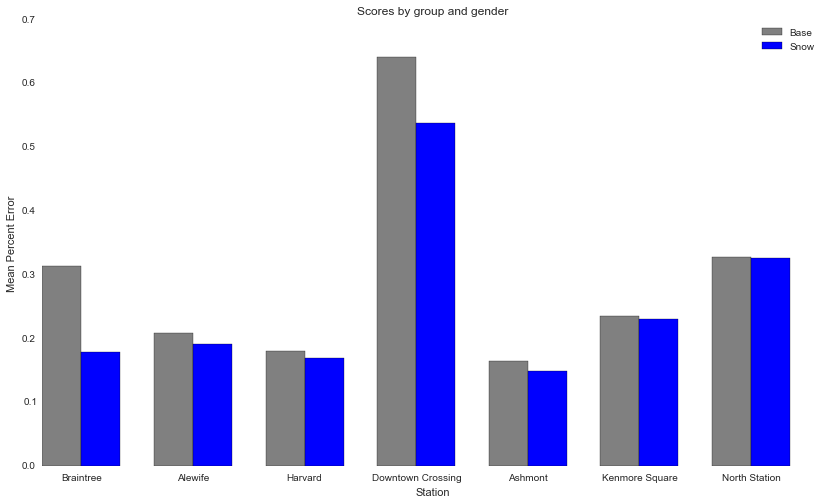

In [206]:
n = len(sub_results)

names = sub_results['name'].values
base_errors = sub_results['base_error'].values
snow_errors = sub_results['extended_error'].values

ind = np.arange(n)
width = .35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(ind, base_errors, width, color='gray')
rects2 = ax.bar(ind+width, snow_errors, width, color='blue')

# add some text for labels, title and axes ticks
ax.set_title('Scores by group and gender')
ax.set_xlabel('Station')
ax.set_ylabel('Mean Percent Error')

ax.set_xticks(ind+width)
ax.set_xticklabels( names )

ax.legend( (rects1[0], rects2[0]), ('Base', 'Snow') )

plt.show()

In all cases, we see a reduction in the percent error. Two cases, however, stand out: Braintree and Downtown Crossing. Both will need additional analysis, but that is outside the scope of this notebook.

## Conclusion ##

By adding snow features to a baseline feature set we were able to improve our predictive models. This tells us that snow certainly has an affect on ridership and can be useful for helping the MBTA predict ridership on a daily basis.